In [80]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2023
## Due Monday 9 Oct, 2023, 11:59 pm

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

For this assignment you may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied. You do not have to include this file in your repository.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [82]:
# d = xr.open_dataset('../../../cfrad.20080604_002217_000_SPOL_v36_SUR.nc')
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 ... 2.496e+04 2.498e+04
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    ...                         ...
    longitude                  float64 ...
    altitude                   float64 ...
    time_coverage_start        |S32 ...
    time_coverage_end          |S32 ...
    time_reference             |S32 ...
    

<xarray.DataArray 'sweep_mode' (sweep: 5)>
[5 values with dtype=|S32]
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
[5 values with dtype=int32]
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
[5 values with dtype=int32]
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


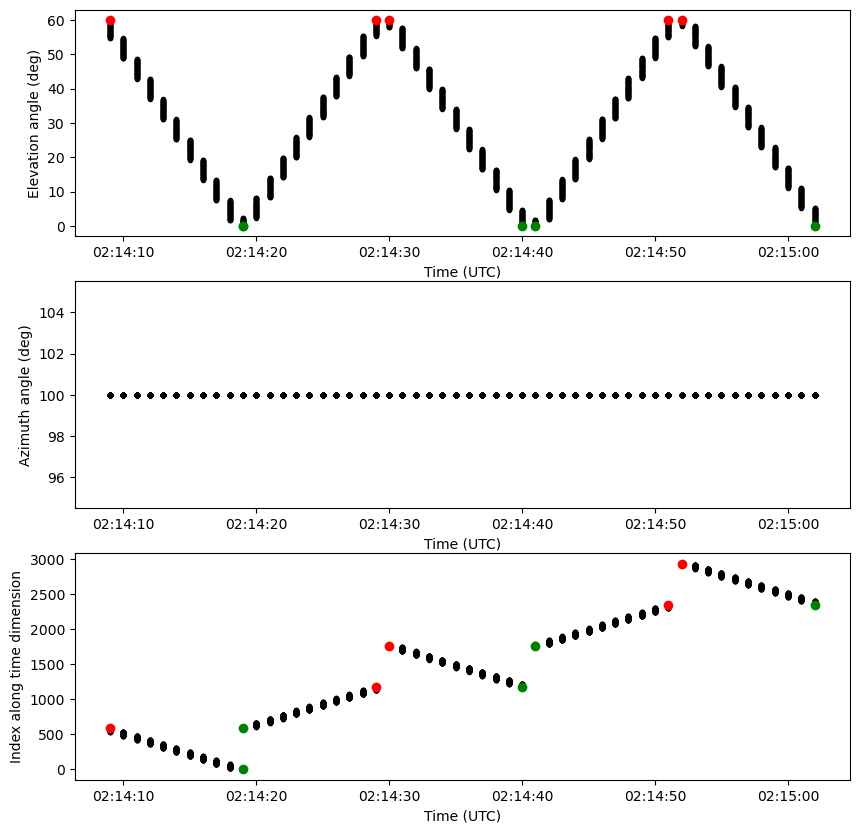

In [83]:
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [84]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  2D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 2D variables, as you see in the sample function call below. `coords_2d` should call another helper function, `spherical_coord_edges(d, scan_idx)` that returns the 1D coordinates along each coordinate direction for that sweep. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

Also print out the shapes of r, az, and el.

In [85]:
def centers_to_edges_1d(x):
    nx_edges = x.shape[0]+1
    xe = np.zeros(nx_edges)
    # Fill in the middle of the grid with average poitions
    xe[1:-1] = (x[1:] + x[:-1])/2.0
    # For the outermost points, use half the spacing of the center points closest to each end
    xe[0] = x[0] - (x[1] - x[0])/2.0
    xe[-1] = x[-1] + (x[-1] - x[-2])/2.0
    return xe

def spherical_coord_edges(d, scan_idx):
    start = d.sweep_start_ray_index[scan_idx].data
    stop = d.sweep_end_ray_index[scan_idx].data
    print(stop-start)
    r = d.range[:]
    r = centers_to_edges_1d(r.data)
    az = d.azimuth[start:stop]
    az = centers_to_edges_1d(az.data)
    el = d.elevation[start:stop]
    el = centers_to_edges_1d(el.data)
    return(r,az,el)
    
def coords_2d(d, scan_idx):
    r,az,el = spherical_coord_edges(d, scan_idx)
    r2D,az2d = np.meshgrid(r,az)
    r2D,el2d = np.meshgrid(r,el)   
    return(r2D, az2d, el2d)

r, az, el = coords_2d(d, scan_idx)
print(r.shape,az.shape,el.shape)

585
[[-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]
 [-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]
 [-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]
 ...
 [-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]
 [-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]
 [-7.50000e+00  7.50000e+00  2.25000e+01 ...  2.49525e+04  2.49675e+04
   2.49825e+04]] [[100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 ...
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` together with a tangent plane system to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar. You will need to define a new variable that gives range along the tangent plane.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

585
[3612619.10789493 3612616.96388439 3612614.81986883 ... 3623134.41203113
 3623140.73189963 3623147.05176577]
[1203122.32742415 1203137.04523742 1203151.76304903 ... 1219469.34780661
 1219479.17612777 1219489.00445595]
[-5108251.24748071 -5108249.30078759 -5108247.35408741 ...
 -5123908.50840194 -5123917.91894515 -5123927.32948562]


<Figure size 640x480 with 0 Axes>

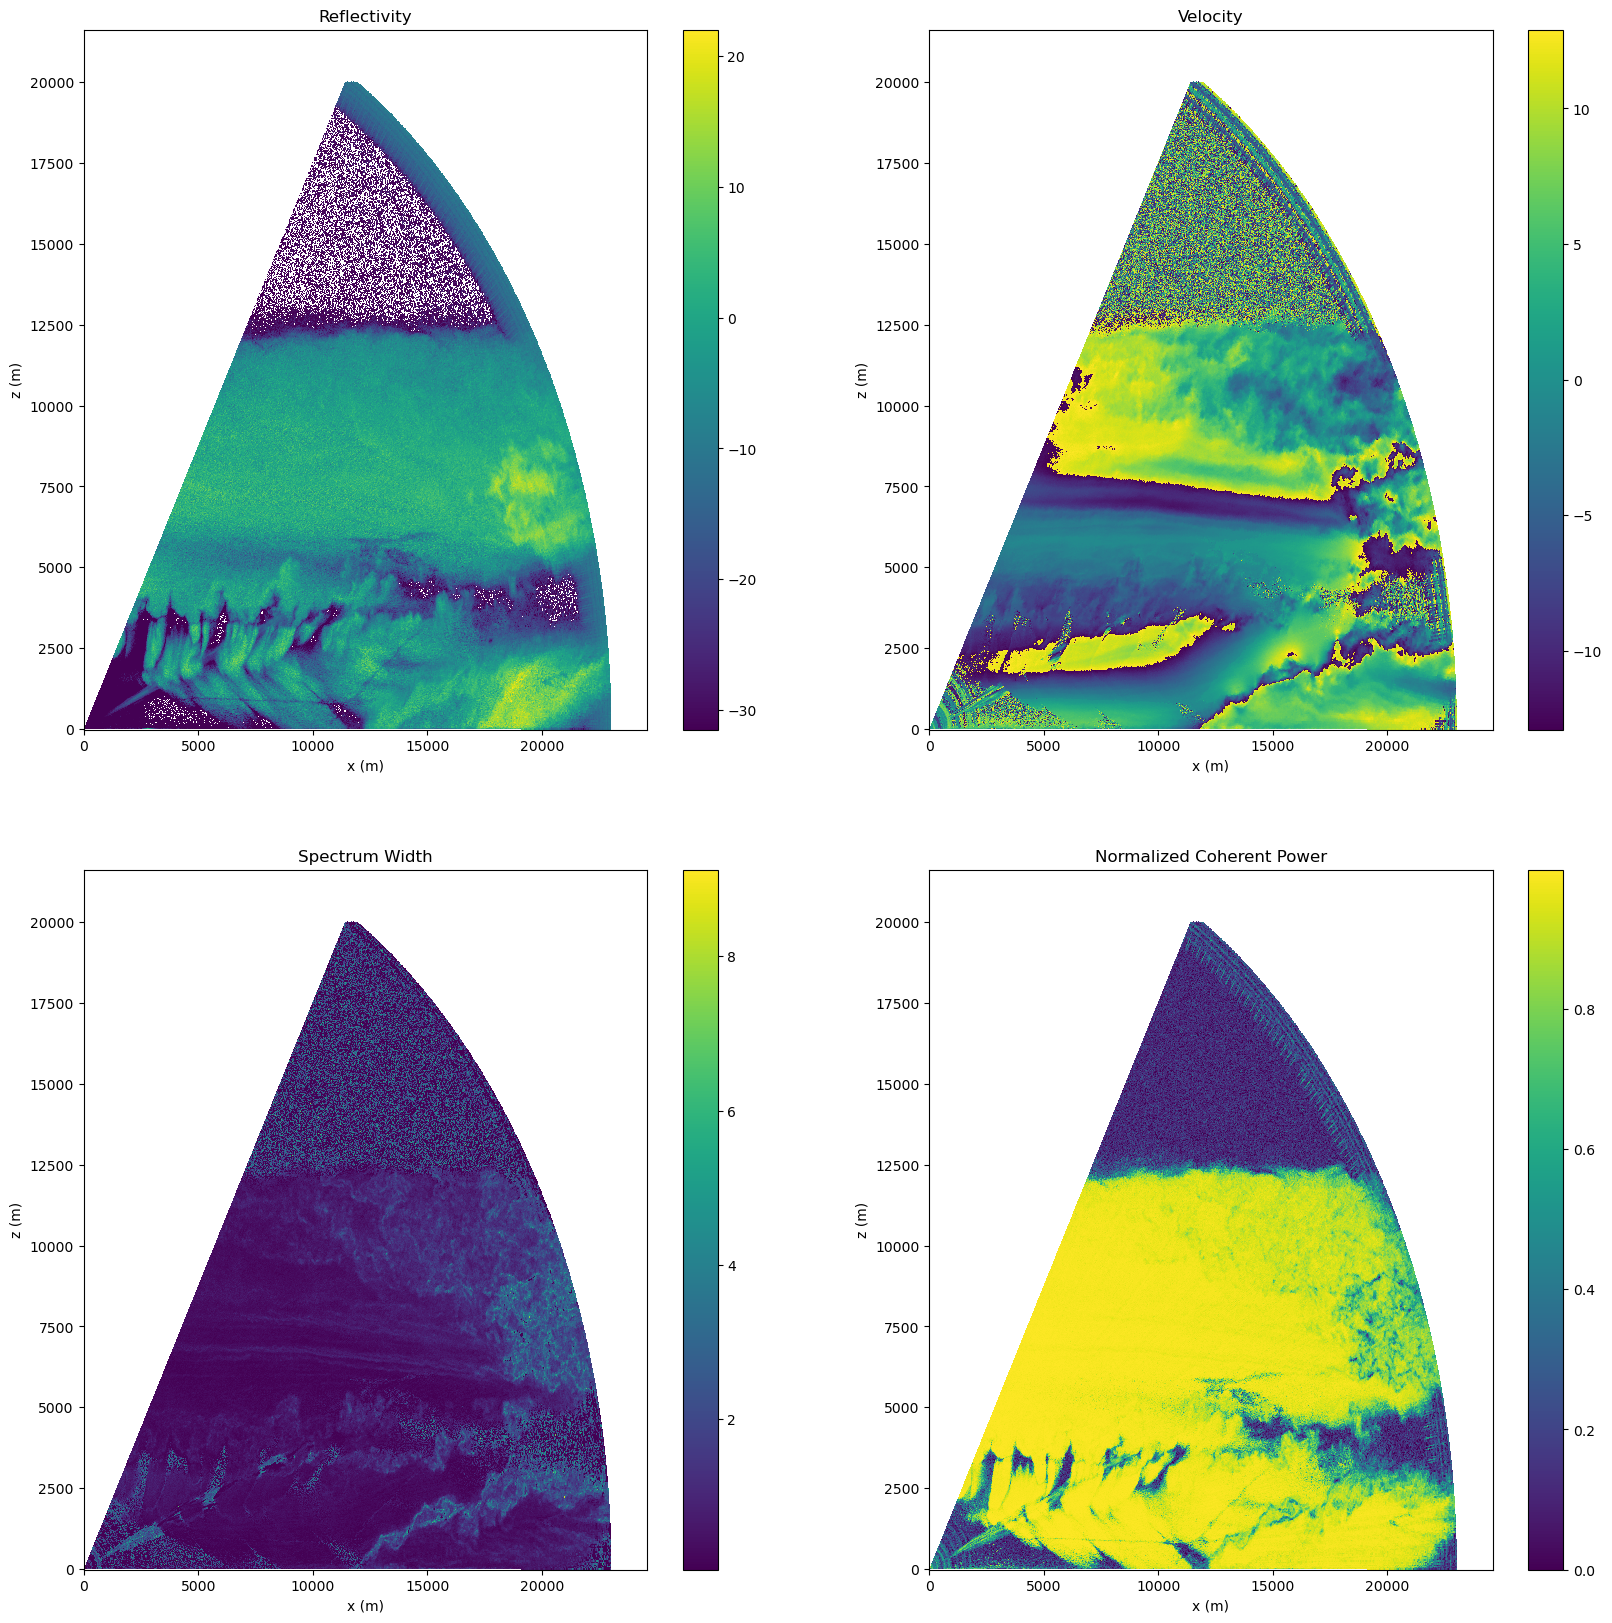

In [86]:
from coords import TangentPlaneCartesianSystem
from coords import RadarCoordinateSystem
r, az, el = coords_2d(d, scan_idx)

start = d.sweep_start_ray_index[scan_idx].data
stop = d.sweep_end_ray_index[scan_idx].data
ref = d.reflectivity[start:stop,:].data
velo = d.velocity[start:stop,:].data
SWidth = d.spectrum_width[start:stop,:].data
Power = d.normalized_coherent_power[start:stop,:].data

RadarObject = RadarCoordinateSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
TPlane = TangentPlaneCartesianSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
RadarX,RadarY,RadarZ = RadarObject.toECEF(r,az,el)
print(RadarZ)
print(RadarX)
print(RadarY)
x,y,z = TPlane.fromECEF(RadarX,RadarY,RadarZ)
x.shape = r.shape
y.shape = r.shape
z.shape = r.shape

import matplotlib.pyplot as plt
fig = plt.figure()
n_rows,n_cols = 2,2,
fig,axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes[0,0].plot
axes[0,0].set_xlabel('x (m)')
axes[0,0].set_ylabel('z (m)')
axes[0,0].set_title('Reflectivity')
ref = axes[0,0].pcolormesh(x,z,ref.data)
plt.colorbar(ref)


axes[0,1].plot
axes[0,1].set_xlabel('x (m)')
axes[0,1].set_ylabel('z (m)')
axes[0,1].set_title('Velocity')
velo = axes[0,1].pcolormesh(x,z,velo.data)
plt.colorbar(velo)

axes[1,0].plot
axes[1,0].set_xlabel('x (m)')
axes[1,0].set_ylabel('z (m)')
axes[1,0].set_title('Spectrum Width')
SWidth = axes[1,0].pcolormesh(x,z,SWidth.data)
plt.colorbar(SWidth)

axes[1,1].plot
axes[1,1].set_xlabel('x (m)')
axes[1,1].set_ylabel('z (m)')
axes[1,1].set_title('Normalized Coherent Power')
Powerplot = axes[1,1].pcolormesh(x,z,Power.data)
plt.colorbar(Powerplot)
    
# axes[1,1].plot
# axes[1,1].set_xlabel('Longitude')
# axes[1,1].set_ylabel('Latitude')
# axes[1,1].set_title('Ground')
# axes[1,1].plot(GroundPlaneX, GroundPlaneY, marker='.', linestyle='none')
# axes[1,1].plot(GroundPlaneXnew, GroundPlaneYnew, marker='.', linestyle='none')
# for tlon, tlat, tlabel in zip(GroundPlaneX, GroundPlaneY, GroundPlaneZ):
#     axes[1,1].text(tlon, tlat, tlabel)
# for tlon, tlat, tlabel in zip(GroundPlaneXnew, GroundPlaneYnew, GroundPlaneZnew):
#     axes[1,1].text(tlon, tlat, tlabel)


**3.** Repeat the plot for question 2, but for an aziuthal equidistant map projection centered at the radar location.

As above, you will to definte a new variable that gives a horizontal distance (a sort of "range") using the coordinates returned from the map projection. This can be calculated in one line of code.

How does this plot compare to the plot defined in tangent plane coordinates?

585
[3612619.10789493 3612616.96388439 3612614.81986883 ... 3623134.41203113
 3623140.73189963 3623147.05176577]
[1203122.32742415 1203137.04523742 1203151.76304903 ... 1219469.34780661
 1219479.17612777 1219489.00445595]
[-5108251.24748071 -5108249.30078759 -5108247.35408741 ...
 -5123908.50840194 -5123917.91894515 -5123927.32948562]
<xarray.DataArray 'latitude' ()>
array(34.72259)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  Latitude
<xarray.DataArray 'longitude' ()>
array(-76.74685)
Attributes:
    long_name:      Longitude
    units:          degrees_east
    standard_name:  Longitude
<xarray.DataArray 'range' ()>
array(15., dtype=float32)


<Figure size 640x480 with 0 Axes>

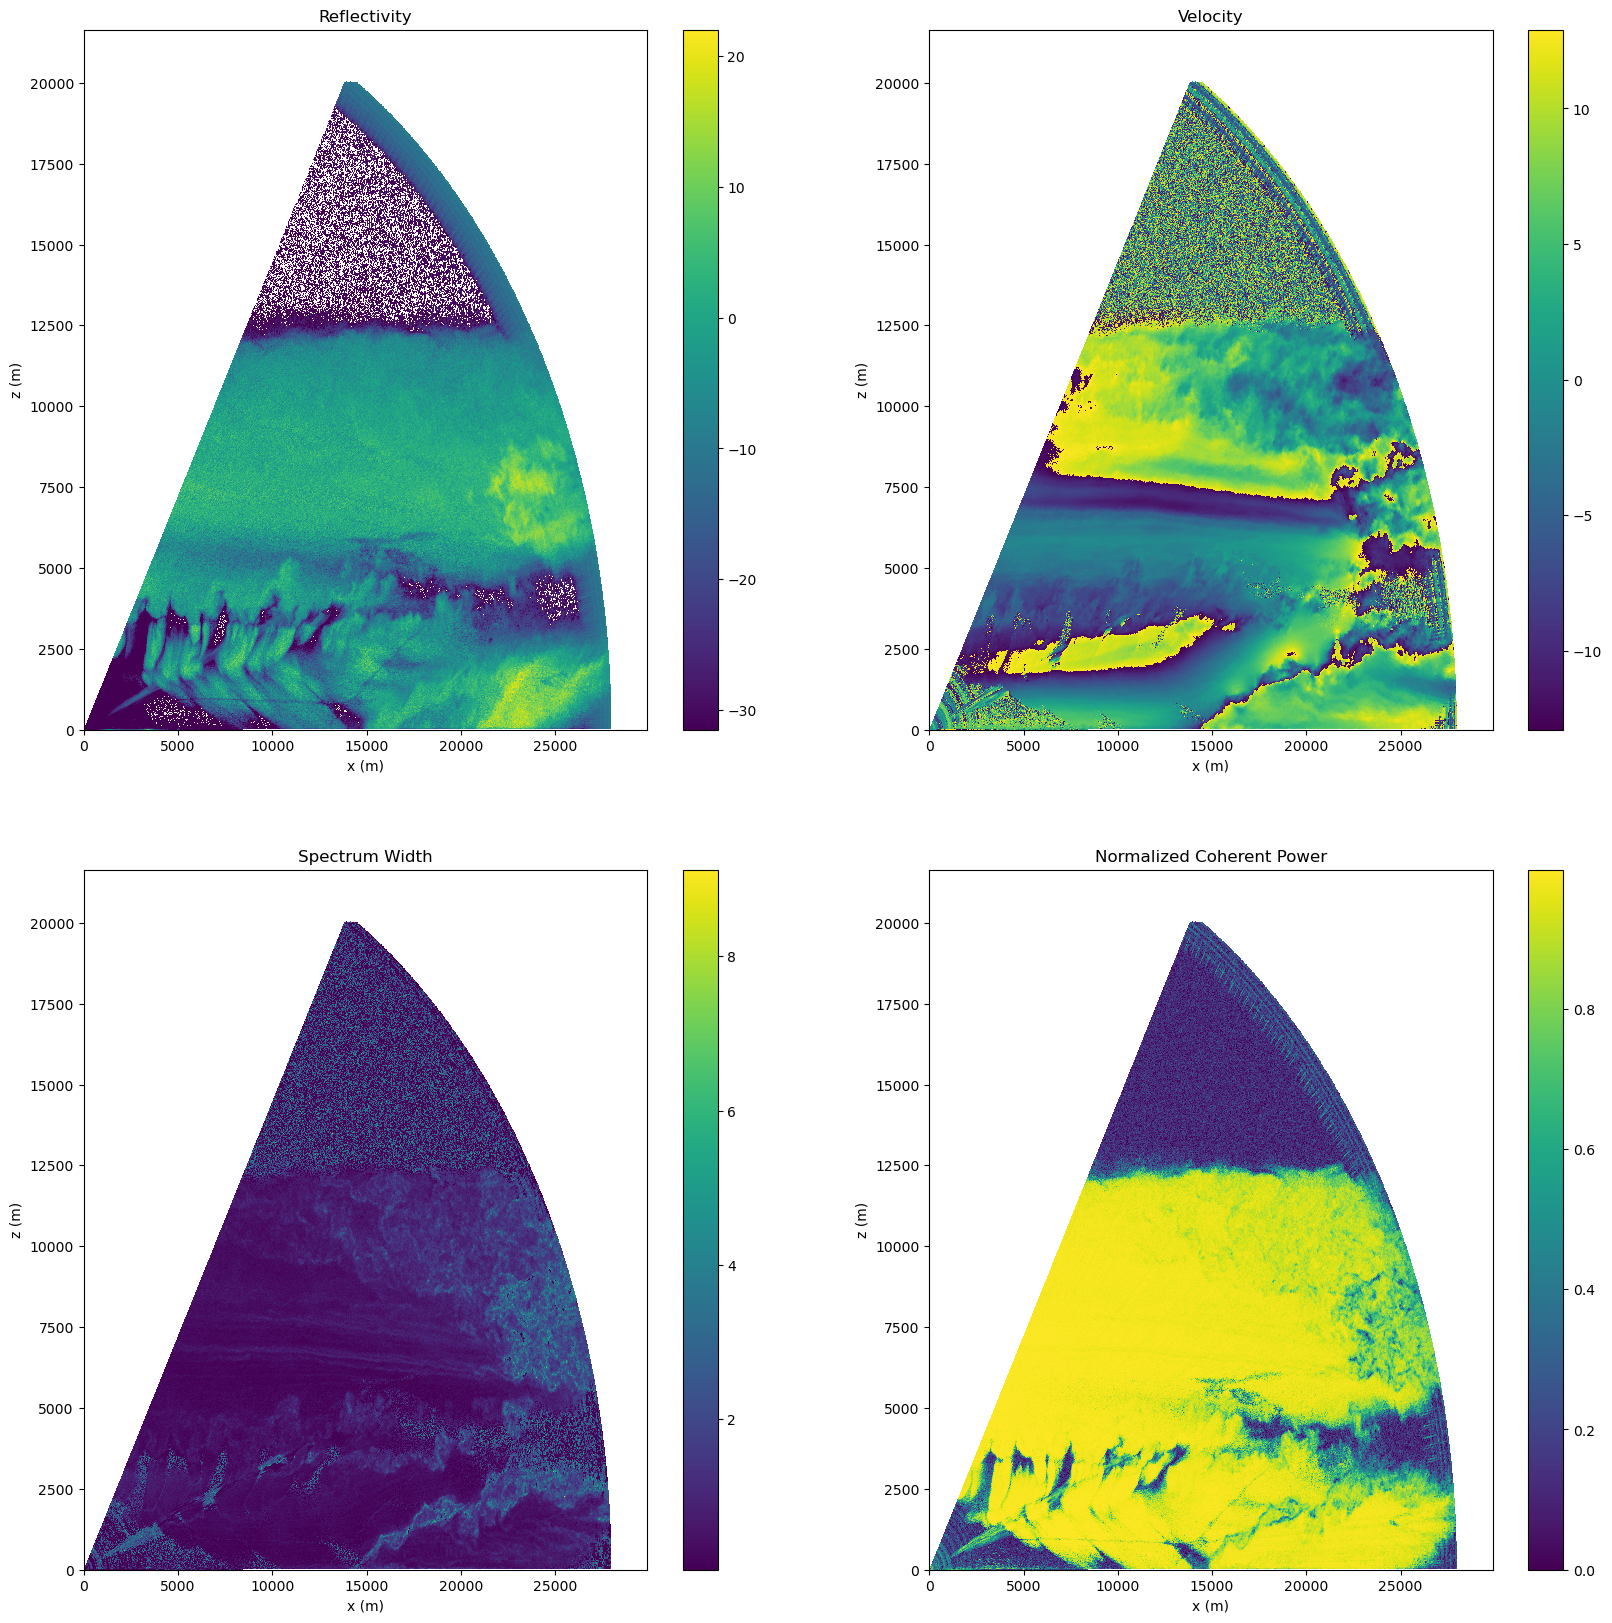

In [87]:
# Where is the radar? What is its gate spacing?
from coords import MapProjection
from coords import RadarCoordinateSystem
r, az, el = coords_2d(d, scan_idx)

start = d.sweep_start_ray_index[scan_idx].data
stop = d.sweep_end_ray_index[scan_idx].data
ref = d.reflectivity[start:stop,:].data
velo = d.velocity[start:stop,:].data
SWidth = d.spectrum_width[start:stop,:].data
Power = d.normalized_coherent_power[start:stop,:].data

RadarObject = RadarCoordinateSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
GenericMapVariableName = MapProjection(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
RadarX,RadarY,RadarZ = RadarObject.toECEF(r,az,el)
print(RadarZ)
print(RadarX)
print(RadarY)
x,y,z = GenericMapVariableName.fromECEF(RadarX,RadarY,RadarZ)
x.shape = r.shape
y.shape = r.shape
z.shape = r.shape

import matplotlib.pyplot as plt
fig = plt.figure()
n_rows,n_cols = 2,2,
fig,axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes[0,0].plot
axes[0,0].set_xlabel('x (m)')
axes[0,0].set_ylabel('z (m)')
axes[0,0].set_title('Reflectivity')
refplot = axes[0,0].pcolormesh(x,z,ref.data)
plt.colorbar(refplot)


axes[0,1].plot
axes[0,1].set_xlabel('x (m)')
axes[0,1].set_ylabel('z (m)')
axes[0,1].set_title('Velocity')
veloplot = axes[0,1].pcolormesh(x,z,velo.data)
plt.colorbar(veloplot)

axes[1,0].plot
axes[1,0].set_xlabel('x (m)')
axes[1,0].set_ylabel('z (m)')
axes[1,0].set_title('Spectrum Width')
SWidthplot = axes[1,0].pcolormesh(x,z,SWidth.data)
plt.colorbar(SWidthplot)

axes[1,1].plot
axes[1,1].set_xlabel('x (m)')
axes[1,1].set_ylabel('z (m)')
axes[1,1].set_title('Normalized Coherent Power')
Powerplot = axes[1,1].pcolormesh(x,z,Power.data)
plt.colorbar(Powerplot)



print('These plots are very very similar to before. The only difference that I can see is that they are more horizontally stretched')
print(d.latitude)
print(d.longitude)
print(d.range[1]-d.range[0])

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

In [101]:
startrange = 9000
stoprange = 9505
steprange = 5

startalt = 2900
stopalt = 3405
stepalt = 5
rangearray = np.arange(startrange, stoprange, steprange)
altarray = np.arange(startalt, stopalt, steprange)


rangearray2D = centers_to_edges_1d(rangearray)
altarray2D = centers_to_edges_1d(altarray)

rangearray2D = rangearray2D[1:-1]
altarray2D = altarray2D[1:-1]

rangearray2D, altarray2D = np.meshgrid(rangearray2D, altarray2D)

print(rangearray2D.shape)
print(rangearray2D)

(100, 100)
[[9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 ...
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]]


**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

In [102]:
# from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
# from metpy.units import units
from metpy.interpolate import interpolate_to_points
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

def spherical_coord_edges_fake(d, scan_idx):
    start = d.sweep_start_ray_index[scan_idx].data
    stop = d.sweep_end_ray_index[scan_idx].data
    print(stop-start)
    r = d.range[:]
    az = d.azimuth[start:stop]
    el = d.elevation[start:stop]
    return(r,az,el)
    
def coords_2d2(d, scan_idx):
    r,az,el = spherical_coord_edges_fake(d, scan_idx)
    r2D,az2d = np.meshgrid(r,az)
    r2D,el2d = np.meshgrid(r,el)   
    return(r2D, az2d, el2d)

r2D, az2D, el2D = coords_2d2(d, scan_idx)

start = d.sweep_start_ray_index[scan_idx].data
stop = d.sweep_end_ray_index[scan_idx].data
ref = d.reflectivity[start:stop,:].data
velo = d.velocity[start:stop,:].data
SWidth = d.spectrum_width[start:stop,:].data
Power = d.normalized_coherent_power[start:stop,:].data
RadarObject = RadarCoordinateSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
TPlane = TangentPlaneCartesianSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
RadarX,RadarY,RadarZ = RadarObject.toECEF(r2D,az2D,el2D)
xnew,ynew,znew = TPlane.fromECEF(RadarX,RadarY,RadarZ)
x2D = xnew.flatten()
z2D = znew.flatten()

range2D = rangearray2D.flatten()
alt2D = altarray2D.flatten()

refflat = ref.flatten()
veloflat = velo.flatten()
SWidthflat = SWidth.flatten()
Powerflat = Power.flatten()

TrueSpot1 = (x2D >= 8750) & (x2D<= 9750)
TrueSpot2 = (z2D >= 2650) & (z2D<= 3650)
TrueSpot = TrueSpot1 & TrueSpot2
refTrue = refflat[TrueSpot]
veloTrue = veloflat[TrueSpot]
SWidthTrue = SWidthflat[TrueSpot]
PowerTrue = Powerflat[TrueSpot]
x2D = x2D[TrueSpot]
z2D = z2D[TrueSpot]


theStack = (np.vstack((x2D,z2D))).T
theStack2 = (np.vstack((range2D, alt2D))).T
print(refTrue.shape)
print(theStack2.shape)
print(theStack.shape)

refinterpLinear = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'linear')
refinterpNearestNeighbor = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'nearest')
refinterpBarnes = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'barnes')

velointerpLinear = interpolate_to_points(theStack, veloTrue, theStack2, interp_type = 'linear')
velointerpNearestNeighbor = interpolate_to_points(theStack, veloTrue, theStack2, interp_type = 'nearest')
velointerpBarnes = interpolate_to_points(theStack, veloTrue, theStack2, interp_type = 'barnes')

SWidthinterpLinear = interpolate_to_points(theStack, SWidthTrue, theStack2, interp_type = 'linear')
SWidthinterpNearestNeighbor = interpolate_to_points(theStack, SWidthTrue, theStack2, interp_type = 'nearest')
SWidthinterpBarnes = interpolate_to_points(theStack, SWidthTrue, theStack2, interp_type = 'barnes')

PowerinterpLinear = interpolate_to_points(theStack, PowerTrue, theStack2, interp_type = 'linear')
PowerinterpNearestNeighbor = interpolate_to_points(theStack, PowerTrue, theStack2, interp_type = 'nearest')
PowerinterpBarnes = interpolate_to_points(theStack, PowerTrue, theStack2, interp_type = 'barnes')


585
(3940,)
(10000, 2)
(3940, 2)


**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

**Some demonstration code** showing some useful array tricks is provided below.

As you can see, all of the interpolations (except nearest neighbor) resolve a higher resolution than the original, which is good, because otherwise I would be confused. The nearest neighbor interpolation is distinctly different because it defines polygons where the entire value inside is interpolated from the nearest neighbors, as the name implies. The Linear and Barnes interpolations are a little trickier. To my eye it looks like the Barnes and Linear interpolations bend the reflectivity in different directions. At the highest point in the higher reflectivity blob, there is distinctly a tilt to the left from the Barnes method and to the right from the linear interpolation. In terms of what I find desirable, I would say the linear interpolation. It is very clear to understand the interpolation happening, and still provides much higher resolution than the original plot.


<Figure size 640x480 with 0 Axes>

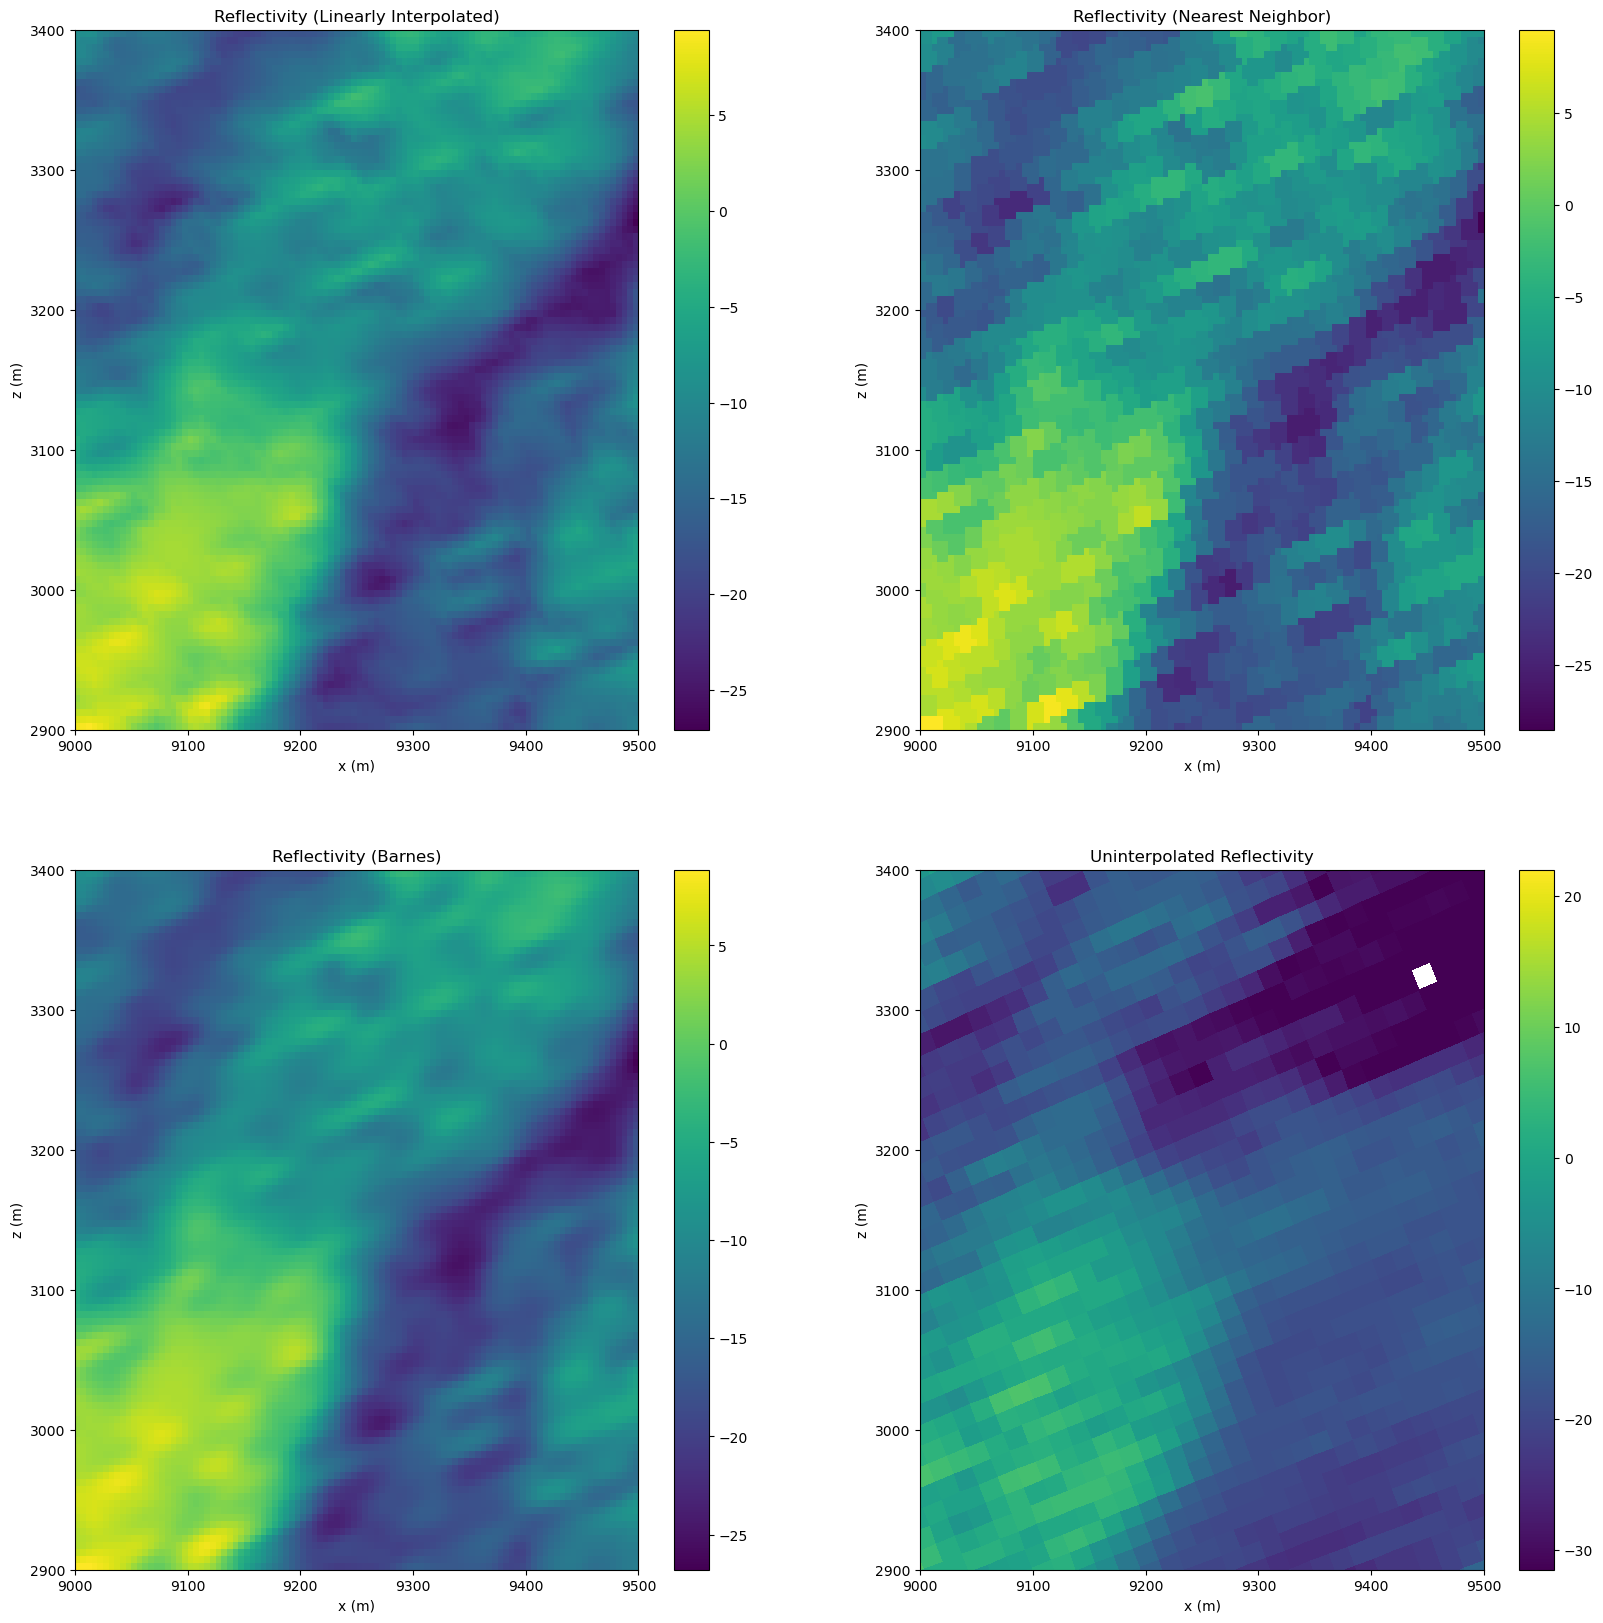

In [128]:
import numpy as np
import matplotlib.pyplot as plt

def BackTo2D(refinterpLinear):
    num_rows = 100
    num_elements_per_row = len(refinterpLinear) // num_rows
    refinterpLinear2D = refinterpLinear[:num_elements_per_row * num_rows].reshape(num_rows, num_elements_per_row)
    return(refinterpLinear2D)
refinterpLinear2D = BackTo2D(refinterpLinear)
refinterpNearestNeighbor2D = BackTo2D(refinterpNearestNeighbor)
refinterpBarnes2D = BackTo2D(refinterpBarnes)
refTrue2D = BackTo2D(refTrue)

fig = plt.figure()
n_rows,n_cols = 2,2,
fig,axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes[0,0].plot
axes[0,0].set_xlabel('x (m)')
axes[0,0].set_ylabel('z (m)')
axes[0,0].set_title('Reflectivity (Linearly Interpolated)')
refplotter = axes[0,0].pcolormesh(rangearray, altarray, refinterpLinear2D)
plt.colorbar(refplotter)


axes[0,1].plot
axes[0,1].set_xlabel('x (m)')
axes[0,1].set_ylabel('z (m)')
axes[0,1].set_title('Reflectivity (Nearest Neighbor)')
veloplotter = axes[0,1].pcolormesh(rangearray, altarray, refinterpNearestNeighbor2D)
plt.colorbar(veloplotter)

axes[1,0].plot
axes[1,0].set_xlabel('x (m)')
axes[1,0].set_ylabel('z (m)')
axes[1,0].set_title('Reflectivity (Barnes)')
SWidthplotter = axes[1,0].pcolormesh(rangearray, altarray, refinterpBarnes2D)
plt.colorbar(SWidthplotter)

axes[1,1].plot
axes[1,1].set_xlabel('x (m)')
axes[1,1].set_ylabel('z (m)')
axes[1,1].set_title('Uninterpolated Reflectivity')
Powerplotter = axes[1,1].pcolormesh(x, z, ref.data)
axes[1, 1].set_xlim(9000, 9500)
axes[1, 1].set_ylim(2900, 3400)
plt.colorbar(Powerplotter)
print('As you can see, all of the interpolations (except nearest neighbor) resolve a higher resolution than the original, which is good, because otherwise I would be confused. The nearest neighbor interpolation is distinctly different because it defines polygons where the entire value inside is interpolated from the nearest neighbors, as the name implies. The Linear and Barnes interpolations are a little trickier. To my eye it looks like the Barnes and Linear interpolations bend the reflectivity in different directions. At the highest point in the higher reflectivity blob, there is distinctly a tilt to the left from the Barnes method and to the right from the linear interpolation. In terms of what I find desirable, I would say the linear interpolation. It is very clear to understand the interpolation happening, and still provides much higher resolution than the original plot.')

In [126]:
refTrue.shape = 

(100, 39)


In [ ]:
b

In [ ]:
s=np.vstack((a,b))

In [ ]:
s

In [ ]:
s.shape

In [ ]:
s.T

In [ ]:
z=np.ones_like(s.T)

In [ ]:
z.flatten()

In [ ]:
np.hstack((a,b))

In [ ]:
z.shape

In [ ]:
np.hstack((z[:,0], z[:,1]))

In [ ]:
a[None,:].shape

In [ ]:
b[:,None].shape

In [ ]:
sq = a[None,:]*b[:,None]
sq

In [ ]:
sel = (sq > 5) & (sq <=10)
sel

In [ ]:
np.argmin(sq)

In [ ]:
np.where(sel)

In [ ]:
np.where?

In [ ]:
x_cond = (ds.x_coord > 5)

ds[ {'x_dim':x_cond, 'y_dim':y_cond} ]